In [1]:
import pandas as pd
import numpy as np
import re
import os
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

## OLS linear curve but linear in parameters

In [2]:
df = pd.read_csv('data/scaled_df.csv')
df.head()

index        DATE     Mp_MP    Mgp_RP     Md_RP     Mp_RP  \
0      0  2020-01-25 -0.003898 -0.004769  0.080294 -0.038166   
1      3  2020-01-26 -0.004223 -0.005169 -0.059368 -0.041348   
2      6  2020-01-27 -0.004548 -0.005563 -0.000459 -0.044529   
3      9  2020-01-28 -0.004873 -0.005963  0.058646 -0.047711   
4     12  2020-01-29 -0.005198 -0.006363  0.081410 -0.050892   

                        PROV     Mr_MP    Mrr_RP  \
0  Newfoundland and Labrador  0.000244 -0.002388   
1  Newfoundland and Labrador  0.000264 -0.002585   
2  Newfoundland and Labrador  0.000284 -0.002781   
3  Newfoundland and Labrador  0.000305 -0.002985   
4  Newfoundland and Labrador  0.000325 -0.003182   

                             HR_NAME  ...      M_PD     Md_MD    Mrr_MD  \
0  Central Regional Health Authority  ...  0.768167  0.559143  0.862697   
1  Central Regional Health Authority  ...  0.768145  0.546676  0.862671   
2  Central Regional Health Authority  ...  0.768154  0.551935  0.862645   
3  Central Regional Health Authority  ...  0.768162  0.557211  0.862618   
4  Central Regional Health Authority  ...  0.768165  0.559243  0.862592   

     Mgp_MD     Mp_MD     Mt_MD     Mw_MD     Mr_MD      M_MD  cases  
0  0.571782  0.254427  0.916392  0.928297  0.059503  0.781982    0.0  
1  0.571728  0.254272  0.916369  0.928274  0.059559  0.778422    0.0  
2  0.571676  0.254118  0.916346  0.928251  0.059615  0.779784    0.0  
3  0.571623  0.253963  0.916323  0.928228  0.059672  0.781150    0.0  
4  0.571569  0.253809  0.916300  0.928205  0.059728  0.781615    0.0  

[5 rows x 45 columns]

In [3]:
# minmax scaler
scaler = MinMaxScaler()
data = df[['deaths']]
data_scale = scaler.fit_transform(data)
df_data_scale = pd.DataFrame(data=data_scale,columns=['scaled_deaths'])

df_new = pd.concat([df, df_data_scale], axis=1)
df_new.head()

index        DATE     Mp_MP    Mgp_RP     Md_RP     Mp_RP  \
0      0  2020-01-25 -0.003898 -0.004769  0.080294 -0.038166   
1      3  2020-01-26 -0.004223 -0.005169 -0.059368 -0.041348   
2      6  2020-01-27 -0.004548 -0.005563 -0.000459 -0.044529   
3      9  2020-01-28 -0.004873 -0.005963  0.058646 -0.047711   
4     12  2020-01-29 -0.005198 -0.006363  0.081410 -0.050892   

                        PROV     Mr_MP    Mrr_RP  \
0  Newfoundland and Labrador  0.000244 -0.002388   
1  Newfoundland and Labrador  0.000264 -0.002585   
2  Newfoundland and Labrador  0.000284 -0.002781   
3  Newfoundland and Labrador  0.000305 -0.002985   
4  Newfoundland and Labrador  0.000325 -0.003182   

                             HR_NAME  ...     Md_MD    Mrr_MD    Mgp_MD  \
0  Central Regional Health Authority  ...  0.559143  0.862697  0.571782   
1  Central Regional Health Authority  ...  0.546676  0.862671  0.571728   
2  Central Regional Health Authority  ...  0.551935  0.862645  0.571676   
3  Central Regional Health Authority  ...  0.557211  0.862618  0.571623   
4  Central Regional Health Authority  ...  0.559243  0.862592  0.571569   

      Mp_MD     Mt_MD     Mw_MD     Mr_MD      M_MD cases  scaled_deaths  
0  0.254427  0.916392  0.928297  0.059503  0.781982   0.0            0.0  
1  0.254272  0.916369  0.928274  0.059559  0.778422   0.0            0.0  
2  0.254118  0.916346  0.928251  0.059615  0.779784   0.0            0.0  
3  0.253963  0.916323  0.928228  0.059672  0.781150   0.0            0.0  
4  0.253809  0.916300  0.928205  0.059728  0.781615   0.0            0.0  

[5 rows x 46 columns]

In [4]:
# select one hr
def df_filter(hr, case):
    df_hr = df_new.loc[df_new['HR_UID']==hr]
    # case flag, if True birng case col, if not, no case col
    col_lst = ['Mt_MP', 'Md_RP', 'Mr_RP', 'Mgp_RP', 'M_MP', 'Mrr_MP', 'Mr_MP', 'Md_MP', 'Mp_RP',
                            'Mrr_RP', 'Mp_MP', 'Mt_RP', 'Mw_MP', 'Mw_RP', 'M_RP', 'Mgp_MP', 'Md_PD', 'Mrr_PD', 'Mgp_PD',
                            'Mp_PD', 'Mt_PD', 'Mw_PD', 'Mr_PD', 'M_PD', 'Md_MD', 'Mrr_MD', 'Mgp_MD',
                           'Mp_MD', 'Mt_MD', 'Mw_MD', 'Mr_MD', 'M_MD']
    if case:
        col_lst.append('cases')
    df_feature = df_hr[col_lst]
    df_label = df_hr[['scaled_deaths']]
    
    return df_feature, df_label

In [5]:
# shape of df_feature: 129
df_feature, df_label = df_filter(3556, True)
X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)
Y_train = y_train.to_numpy().reshape(-1,)

## HR: City of Ottawa Health Unit

In [6]:
olsmod = sm.OLS(Y_train, X_train)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.6087
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.768
Time:                        09:49:20   Log-Likelihood:                 538.52
No. Observations:                 103   AIC:                            -1059.
Df Residuals:                      94   BIC:                            -1035.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mt_MP         -0.0057      0.007     -0.817      0.4

## OLS Analytics:
### R squared
- the higher the R-squared, the better the model fits your data

### P value (significant level: 0.05)
- All p-values are quite high, falling above 0.05, while all feature don't account for significant importances on predictors

In [7]:
y_pred = olsres.predict(X_test)
result = mean_squared_error(y_test, y_pred, squared=False)
print('rmse:', result)

rmse: 0.0017946833987900657


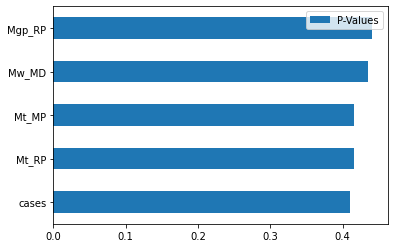

In [12]:
# top 5 features with lowest p-values
df_pvalues = olsres.pvalues.to_frame().sort_values(by=[0], ascending=True)

ax = df_pvalues.head(5).plot(kind='barh')
ax.legend(["P-Values"]);

## fitted line plots

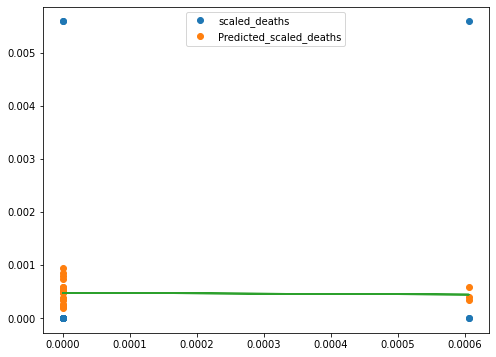

In [13]:
## fitted line plots
x = X_test['cases']

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y_test['scaled_deaths'], 'o', label="data")
ax.plot(x, y_pred, 'o', label="data")
ax.legend(["scaled_deaths", 'Predicted_scaled_deaths']);

m, b = np.polyfit(x, y_pred, 1)
ax.plot(x, m*x + b)

## OLS Analytics:
### R squared
- the higher the R-squared, the better the model fits your data

### P value (significant level: 0.05)
- All p-values are quite high, falling above 0.05, while all feature don't account for significant importances on predictors

## HR: montréal 2406
- top death counts: 2927 (till June 1st)

In [14]:
df_feature, df_label = df_filter(2406, True)
X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)
Y_train = y_train.to_numpy().reshape(-1,)

In [15]:
olsmod = sm.OLS(Y_train, X_train)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     18.66
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           1.83e-16
Time:                        09:53:13   Log-Likelihood:                 97.921
No. Observations:                 103   AIC:                            -177.8
Df Residuals:                      94   BIC:                            -154.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mt_MP         -0.4891      0.140     -3.485      0.0

## OLS Analytics:
### R squared
- the higher the R-squared, the better the model fits your data
- regression model for montréal performs much better than City of Ottawa Health Unit

### P value (significant level: 0.05)
- `Most features have significant importance on the predictor variable since the p-value falls below 0.05`
- Conversely, a larger (insignificant) p-value suggests that changes in the predictor are not associated with changes in the response

### coefficient
- `feature: Mw_MP, Mw_PD, Mr_PD have large coefficient value, indicating that 1 unit of death count increased, the relative amount of features would also increase by its corresponding percentage.`
- Conversely,features like Mt_MP, Mt_PD have large negative value, indicating that 1 unit of death count increased, the relative amount of features would also drop by its corresponding percentage

In [16]:
y_pred = olsres.predict(X_test)
result = mean_squared_error(y_test, y_pred, squared=False)
print('rmse:', result)

rmse: 0.2656810048105956


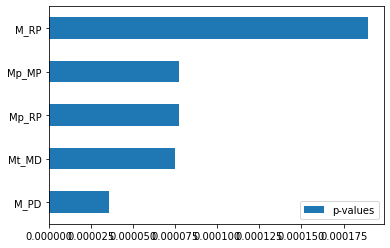

In [17]:
# top 5 features with lowest p-values
df_pvalues = olsres.pvalues.to_frame().sort_values(by=[0], ascending=True)
ax = df_pvalues.head(5).plot(kind='barh')
ax.legend(["p-values"]);

## Fitted Line Plot

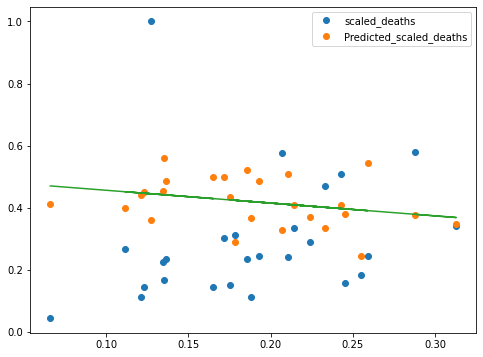

In [18]:
x = X_test['cases']

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y_test['scaled_deaths'], 'o', label="data")
ax.plot(x, y_pred, 'o', label="data")
ax.legend(["scaled_deaths", 'Predicted_scaled_deaths']);
m, b = np.polyfit(x, y_pred, 1)
ax.plot(x, m*x + b)

## HR: toronto 3595
- top death counts: 828 (till June 1st)

In [19]:
df_feature, df_label = df_filter(3595, True)
X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)
Y_train = y_train.to_numpy().reshape(-1,)

In [20]:
olsmod = sm.OLS(Y_train, X_train)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     22.62
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           7.14e-19
Time:                        09:53:58   Log-Likelihood:                 210.73
No. Observations:                 103   AIC:                            -403.5
Df Residuals:                      94   BIC:                            -379.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mt_MP         -0.0096      0.055     -0.174      0.8

/Users/denisechen/Desktop/Work/COVID19/P22/venv/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/denisechen/Desktop/Work/COVID19/P22/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/denisechen/Desktop/Work/COVID19/P22/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/denisechen/Desktop/Work/COVID19/P22/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


## OLS Analytics:
### R squared
- the higher the R-squared, the better the model fits your data

### P value (significant level: 0.05)
- `feature: Md_RP, M_MP, Mp_RP, M_PD, cases has significant importance on the predictor variable since the p-value falls below 0.05`
- Conversely, a larger (insignificant) p-value suggests that changes in the predictor are not associated with changes in the response

### coefficient
- `feature: cases has large coefficient value, indicating that 1 unit of death count increased, the relative amount of features would also increase by its corresponding percentage.`

In [21]:
y_pred = olsres.predict(X_test)
result = mean_squared_error(y_test, y_pred, squared=False)
print('rmse:', result)

rmse: 0.06636703528191595


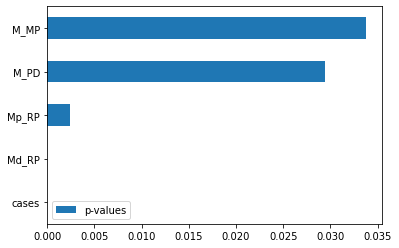

In [23]:
# top 5 features with lowest p-values
df_pvalues = olsres.pvalues.to_frame().sort_values(by=[0], ascending=True)
ax = df_pvalues.head(5).plot(kind='barh')
ax.legend(["p-values"]);

## fitted line plots

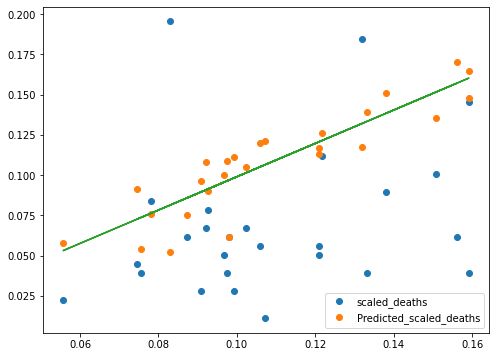

In [24]:
## fitted line plots
x = X_test['cases']

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y_test['scaled_deaths'], 'o', label="data")
ax.plot(x, y_pred, 'o', label="data")
ax.legend(["scaled_deaths", 'Predicted_scaled_deaths']);

m, b = np.polyfit(x, y_pred, 1)
ax.plot(x, m*x + b)

## HR: laval 2413
- top death counts: 608 (till June 1st)

In [25]:
df_feature, df_label = df_filter(2413, True)
X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)
Y_train = y_train.to_numpy().reshape(-1,)

In [26]:
olsmod = sm.OLS(Y_train, X_train)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     12.81
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           2.65e-12
Time:                        09:54:32   Log-Likelihood:                 235.64
No. Observations:                 103   AIC:                            -453.3
Df Residuals:                      94   BIC:                            -429.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mt_MP         -0.0477      0.052     -0.914      0.3

## OLS Analytics:
### R squared
- the higher the R-squared, the better the model fits your data

### P value (significant level: 0.05)
- `feature: cases has significant importance on the predictor variable since the p-value falls below 0.05`
- Conversely, a larger (insignificant) p-value suggests that changes in the predictor are not associated with changes in the response

### coefficient
- `feature: cases has large coefficient value, indicating that 1 unit of death count increased, the relative amount of features would also increase by its corresponding percentage.`

In [27]:
y_pred = olsres.predict(X_test)
result = mean_squared_error(y_test, y_pred, squared=False)
print('rmse:', result)

rmse: 0.05255753083943318


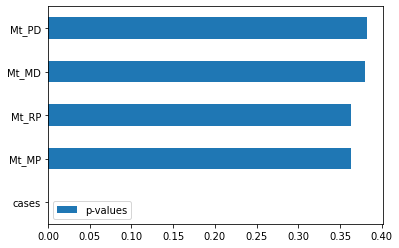

In [28]:
# top 5 features with lowest p-values
df_pvalues = olsres.pvalues.to_frame().sort_values(by=[0], ascending=True)
ax = df_pvalues.head(5).plot(kind='barh')
ax.legend(["p-values"]);

## fitted line plots

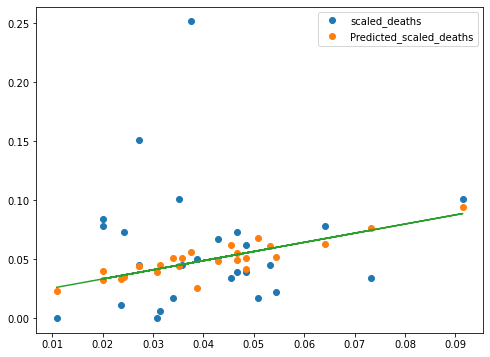

In [29]:
## fitted line plots
x = X_test['cases']

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y_test['scaled_deaths'], 'o', label="data")
ax.plot(x, y_pred, 'o', label="data")
ax.legend(["scaled_deaths", 'Predicted_scaled_deaths']);

m, b = np.polyfit(x, y_pred, 1)
ax.plot(x, m*x + b)

## HR: montérégie 2416
- top death counts: 388 (till June 1st)

In [30]:
df_feature, df_label = df_filter(2416, True)
X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)
Y_train = y_train.to_numpy().reshape(-1,)

In [31]:
olsmod = sm.OLS(Y_train, X_train)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     10.20
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           3.74e-10
Time:                        09:54:59   Log-Likelihood:                 260.15
No. Observations:                 103   AIC:                            -502.3
Df Residuals:                      94   BIC:                            -478.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mt_MP         -0.0703      0.049     -1.445      0.1

## OLS Analytics:
### R squared
- the higher the R-squared, the better the model fits your data

### P value (significant level: 0.05)
- `feature: Md_RP, M_MP, Md_MP, Mp_RP, Mp_MP, M_RP, Mrr_PD, cases has significant importance on the predictor variable since the p-value falls below 0.05`
- Conversely, a larger (insignificant) p-value suggests that changes in the predictor are not associated with changes in the response

### coefficient
- `feature: cases has large coefficient value, indicating that 1 unit of death count increased, the relative amount of features would also increase by its corresponding percentage.`

In [32]:
y_pred = olsres.predict(X_test)
result = mean_squared_error(y_test, y_pred, squared=False)
print('rmse:', result)

rmse: 0.048069695897954276


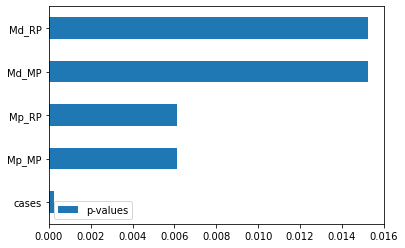

In [33]:
# top 5 features with lowest p-values
df_pvalues = olsres.pvalues.to_frame().sort_values(by=[0], ascending=True)
ax = df_pvalues.head(5).plot(kind='barh')
ax.legend(["p-values"]);

## fitted line plots

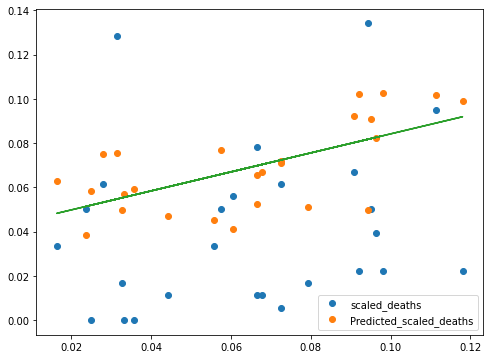

In [34]:
## fitted line plots
x = X_test['cases']

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y_test['scaled_deaths'], 'o', label="data")
ax.plot(x, y_pred, 'o', label="data")
ax.legend(["scaled_deaths", 'Predicted_scaled_deaths']);

m, b = np.polyfit(x, y_pred, 1)
ax.plot(x, m*x + b)

## HR: peel 3553
- top death counts: 276 (till June 1st)

In [35]:
df_feature, df_label = df_filter(3553, True)
X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)
Y_train = y_train.to_numpy().reshape(-1,)

In [36]:
olsmod = sm.OLS(Y_train, X_train)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     15.19
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           4.27e-14
Time:                        09:55:29   Log-Likelihood:                 320.19
No. Observations:                 103   AIC:                            -622.4
Df Residuals:                      94   BIC:                            -598.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mt_MP          0.0051      0.036      0.140      0.8

## OLS Analytics:
### R squared
- the higher the R-squared, the better the model fits your data

### P value (significant level: 0.05)
- `feature: Md_RP, Mr_RP, M_MP, Mr_MP, Md_MP, Mp_RP, Mp_MP, M_RP, Mr_PD, M_PD, Mr_MD, M_MD, cases has significant importance on the predictor variable since the p-value falls below 0.05`
- Conversely, a larger (insignificant) p-value suggests that changes in the predictor are not associated with changes in the response

### coefficient
- `feature: cases has large coefficient value, indicating that 1 unit of death count increased, the relative amount of features would also increase by its corresponding percentage.`

In [37]:
y_pred = olsres.predict(X_test)
result = mean_squared_error(y_test, y_pred, squared=False)
print('rmse:', result)

rmse: 0.03479635526207935


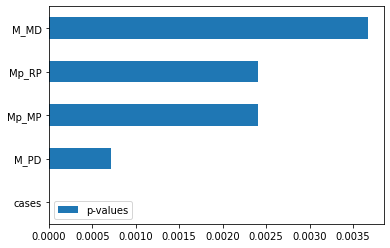

In [38]:
# top 5 features with lowest p-values
df_pvalues = olsres.pvalues.to_frame().sort_values(by=[0], ascending=True)
ax = df_pvalues.head(5).plot(kind='barh')
ax.legend(["p-values"]);

## fitted line plots

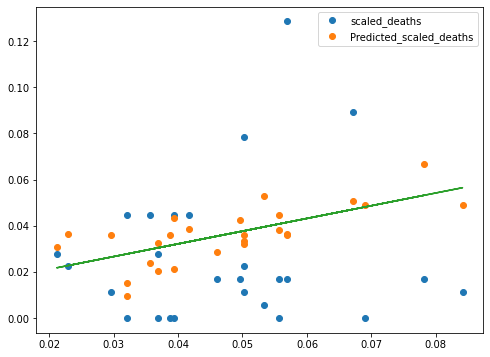

In [39]:
## fitted line plots
x = X_test['cases']

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y_test['scaled_deaths'], 'o', label="data")
ax.plot(x, y_pred, 'o', label="data")
ax.legend(["scaled_deaths", 'Predicted_scaled_deaths']);

m, b = np.polyfit(x, y_pred, 1)
ax.plot(x, m*x + b)

## HR: mauricie 2404 (Quebec)
- top death counts: 203 (till June 1st)

In [40]:
df_feature, df_label = df_filter(2404, True)
X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)
Y_train = y_train.to_numpy().reshape(-1,)

In [41]:
olsmod = sm.OLS(Y_train, X_train)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     10.26
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           3.31e-10
Time:                        09:55:56   Log-Likelihood:                 349.95
No. Observations:                 103   AIC:                            -681.9
Df Residuals:                      94   BIC:                            -658.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mt_MP          0.0037      0.025      0.147      0.8

## OLS Analytics:
### R squared
- the higher the R-squared, the better the model fits your data

### P value (significant level: 0.05)
- `feature: Mr_RP, M_MP, Mr_MP, M_RP, Md_PD, Mrr_PD, Mgp_PD, Mp_PD, Mr_PD, M_PD, Mr_MD, M_MD has significant importance on the predictor variable since the p-value falls below 0.05`
- Conversely, a larger (insignificant) p-value suggests that changes in the predictor are not associated with changes in the response


In [42]:
y_pred = olsres.predict(X_test)
result = mean_squared_error(y_test, y_pred, squared=False)
print('rmse:', result)

rmse: 0.01186432637603297


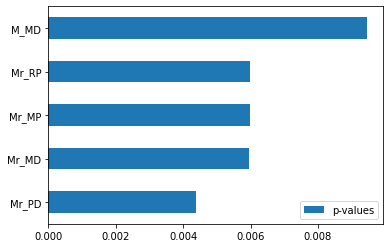

In [43]:
# top 5 features with lowest p-values
df_pvalues = olsres.pvalues.to_frame().sort_values(by=[0], ascending=True)
ax = df_pvalues.head(5).plot(kind='barh')
ax.legend(["p-values"]);

## fitted line plots

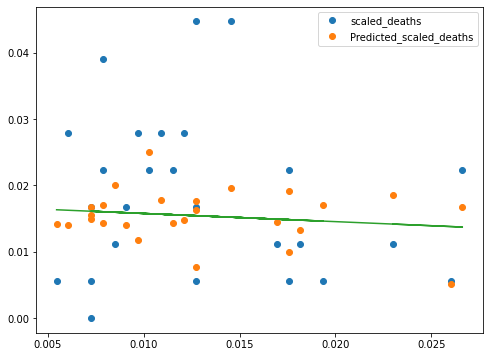

In [44]:
## fitted line plots
x = X_test['cases']

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y_test['scaled_deaths'], 'o', label="data")
ax.plot(x, y_pred, 'o', label="data")
ax.legend(["scaled_deaths", 'Predicted_scaled_deaths']);

m, b = np.polyfit(x, y_pred, 1)
ax.plot(x, m*x + b)